### Icevision

In [2]:
import torch
import torchvision
scripted_model = torch.jit.load("/root/data/experiments/cv2/20_Jul_2022_00_14_15_icevision_maskrcnn/scripting_cpu_test_28_34_224_58.pt")

In [3]:
from pycocotools.cocoeval import COCOeval
from ceruleanml.coco_stats import all_sample_stat_lists
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from ceruleanml import preprocess
from ceruleanml import data
from icevision import models, parsers, show_records, tfms, Dataset, Metric, COCOMetric, COCOMetricType

In [4]:
run_list = [[224, 30]]*1 # List of tuples, where the tuples are [px size, training time in minutes]
# run_list = [[64, 1]]*1+[[128, 1]]*1+[[224, 1]]*1 +[[512, 1]]*1
init_size = run_list[0][0]
negative_sample_count = 0
negative_sample_count_val = 0
area_thresh = 0

In [5]:
data_path = "/root/"
mount_path = "/root/data"

val_set = "val-with-context-512"
tiled_images_folder_val= "tiled_images"
json_name_val = "instances_TiledCeruleanDatasetV2.json"
coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"
remove_list=["ambiguous", "natural_seep"]
class_names_to_keep=[
            "background",
            "infra_slick",
            "recent_vessel",
        ]
remap_dict = {  # only remaps coincident and old to recent
            3: 4,
            5: 4,
        }

# since we remove ambiguous and natural seep and remap all vessels to 1 and include background
num_classes = 3 
class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

record_collection_with_negative_small_filtered_val = preprocess.load_set_record_collection(
    coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=False, class_names_to_keep=class_names_to_keep,
    remap_dict=remap_dict, remove_list=remove_list
)
record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=init_size)])
valid_ds = Dataset(record_collection_with_negative_small_filtered_val, valid_tfms)

Annotations before filtering classes: 352
Images before filtering classes: 5883
Annotations after filtering classes: 308
Images after filtering classes: 5849


  0%|          | 0/308 [00:00<?, ?it/s]

In [27]:
import numpy as np
test_img = valid_ds[10].img

In [7]:
torch.Tensor(np.moveaxis(test_img,2,0)).shape

torch.Size([3, 224, 224])

In [8]:
[torch.Tensor(np.moveaxis(test_img,2,0))/255]

[tensor([[[0.28235, 0.23137, 0.29804,  ..., 0.29804, 0.30588, 0.32549],
          [0.27843, 0.24706, 0.30588,  ..., 0.29020, 0.26667, 0.29412],
          [0.29804, 0.23137, 0.26275,  ..., 0.28627, 0.35294, 0.30980],
          ...,
          [0.26667, 0.25098, 0.25882,  ..., 0.31373, 0.32941, 0.30588],
          [0.26667, 0.27451, 0.28235,  ..., 0.32549, 0.30196, 0.27843],
          [0.29804, 0.31373, 0.27451,  ..., 0.25098, 0.29020, 0.30588]],
 
         [[0.37255, 0.37647, 0.37647,  ..., 0.53333, 0.52941, 0.52941],
          [0.37255, 0.37647, 0.37647,  ..., 0.53333, 0.53333, 0.53333],
          [0.37255, 0.37255, 0.37647,  ..., 0.53333, 0.53333, 0.53333],
          ...,
          [0.31765, 0.32157, 0.32157,  ..., 0.50196, 0.49804, 0.49804],
          [0.31765, 0.32157, 0.32157,  ..., 0.49804, 0.49804, 0.49804],
          [0.31765, 0.32157, 0.32157,  ..., 0.49804, 0.49804, 0.49804]],
 
         [[0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000,

In [10]:
len([torch.Tensor(np.moveaxis(test_img,2,0))/255])

1

maskrcnn wants a list of 3D arrays with length of list as batch size, Fastai Unet wants a 4D array with 0th dim as batch size

In [30]:
losses, pred_list = scripted_model([torch.Tensor(np.moveaxis(test_img,2,0))/255])

fastai returns a 2D array of logits. logits need to be converted to confidence probabilities. Mask RCNN returns a losses array we don't use and a list of dictionaries containing detections.

In [31]:
len(pred_list)

1

* bbox coords are not normalized. 
* dict values are tensors until post processed with conf thresholding.
* length of value list indicates how many instances detected both low and high confidence
* 

Mask R-CNN mask values are not logits, they are 0 to 1 confidence probabilities. the torchscript model applies softmax unlike the fastai unet model where we do that after inference.

bbox coord order?

why is lowest probability 22%? or why is there a cut off?

In [32]:
pred_list[0]['scores']

tensor([0.99966, 0.26242], grad_fn=<IndexBackward0>)

In [33]:
pred_list[0]['labels']

tensor([2, 1])

In [34]:
pred_list[0]['masks'].shape

torch.Size([2, 1, 224, 224])

In [35]:
pred_list[0]['masks']

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<UnsqueezeBackward0>)

In [36]:
%matplotlib inline
import skimage.io as skio

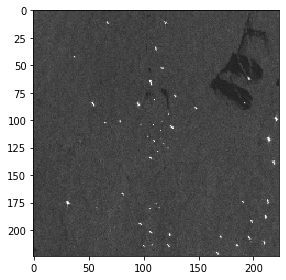

In [37]:
skio.imshow(test_img[:,:,0])

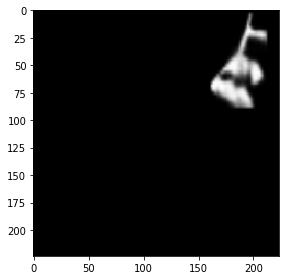

In [48]:
skio.imshow(pred_list[0]['masks'][0,0,:,:].detach().cpu().numpy())

In [51]:
import matplotlib.pyplot as plt

In [57]:
test = pred_list[0]['masks'][0,0,:,:].detach().cpu().numpy().flatten()

In [61]:
np.ma.masked_where(test!=0, test)

masked_array(data=[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20,
            dtype=float32)

(array([          0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,
                  0,           0,       

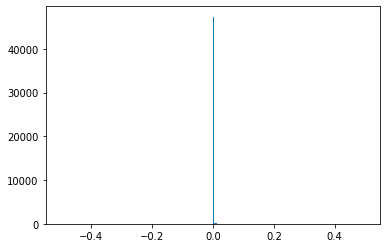

In [63]:
plt.hist(np.ma.masked_where(test!=0, test), bins = 300)

In [45]:
torch.max(pred_list[0]['masks'])

tensor(0.98904, grad_fn=<MaxBackward1>)

In [46]:
torch.min(pred_list[0]['masks'])

tensor(0., grad_fn=<MinBackward1>)

In [15]:
bbox_conf_threshold = .5

In [65]:

from ceruleanml.inference import apply_conf_threshold_instances, apply_conf_threshold_masks

In [66]:
pred_dict = apply_conf_threshold_instances(pred_list[0], bbox_conf_threshold=.5)

In [67]:
pred_dict

{'boxes': [tensor([162.21098,   2.78007, 212.86314,  88.10117], grad_fn=<SelectBackward0>)],
 'labels': [tensor(2)],
 'scores': [tensor(0.99966, grad_fn=<SelectBackward0>)],
 'masks': [tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<SelectBackward0>)]}

In [85]:
merged_class_arr = apply_conf_threshold_masks(pred_dict, mask_conf_threshold=.80)

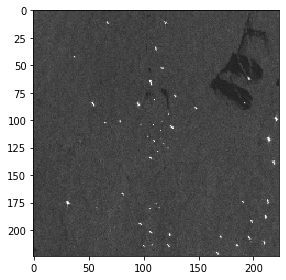

In [87]:
skio.imshow(test_img[:,:,0])

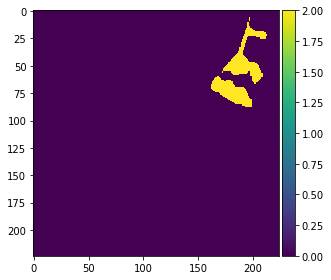

In [72]:
skio.imshow(merged_class_arr.detach().cpu().numpy())

### Fastai

In [1]:
from ceruleanml import data
from ceruleanml import evaluation
from ceruleanml import preprocess
import os, random
import skimage.io as skio
import numpy as np
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
bs_d ={512:4, 256:32, 224:32, 128:64, 64:256}
lr_d = {512:3e-4, 256:1e-3, 224:3e-3, 128:3e-3, 64:1e-2}
arch_d = {18: resnet18, 34: resnet34, 50: resnet50}


size=224
bs = bs_d[size]
n="all"
arch=34
epochs = 10
freeze = 0
negative_sample_count = 0
negative_sample_count_val = 0
area_thresh = 10

In [2]:
if not 'this_cell_has_been_run_already' in locals():

    ### Parsing COCO Dataset with Icevision

    class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
    class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

    mount_path = "/root/"
    train_set = "train-with-context-512"
    tiled_images_folder_train = "tiled_images"
    json_name_train = "instances_TiledCeruleanDatasetV2.json"

    coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
    tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
    val_set = "val-with-context-512"
    tiled_images_folder_val= "tiled_images"
    json_name_val = "instances_TiledCeruleanDatasetV2.json"
    coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
    tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

    #with aux files
    # with_context=True
    # mount_path = "/root/"
    # train_set = "train-with-context-512"
    # tiled_images_folder_train = "tiled_images"
    # json_name_train = "instances_TiledCeruleanDatasetV2.json"

    # coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
    # tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
    # val_set = "val-with-context-512"
    # tiled_images_folder_val= "tiled_images"
    # json_name_val = "instances_TiledCeruleanDatasetV2.json"
    # coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
    # tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"


    class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
    class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

    # f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json"

    ## looking at area distribution to find area threshold

    # df = preprocess.get_area_df(coco_json_path_train, tiled_images_folder_train)
    # df

    record_collection_with_negative_small_filtered_train = preprocess.load_set_record_collection(
        coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count, preprocess=False
    )
    record_ids_train = record_collection_to_record_ids(record_collection_with_negative_small_filtered_train)

    record_collection_with_negative_small_filtered_val = preprocess.load_set_record_collection(
        coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=False
    )
    record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

    assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

    train_val_record_ids = record_ids_train + record_ids_val
    combined_record_collection = record_collection_with_negative_small_filtered_train + record_collection_with_negative_small_filtered_val

    def get_val_indices(combined_ids, val_ids):
        return list(range(len(combined_ids)))[-len(val_ids):]

    #show_data.show_records(random.choices(combined_train_records, k=9), ncols=3)

    ### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser. aug_transforms can only be used with_context=True

    val_indices = get_val_indices(train_val_record_ids, record_ids_val)

    def get_image_by_record_id(record_id):
        return get_image_path(combined_record_collection, record_id)

    def get_mask_by_record_id(record_id):
        return record_to_mask(combined_record_collection, record_id)

    this_cell_has_been_run_already = True
else:
    print('skipped')


  0%|          | 0/3863 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

In [4]:
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.data.transforms import IndexSplitter
from fastai.vision.augment import aug_transforms, Resize

In [5]:
coco_seg_dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=class_ints)), # ImageBlock is RGB by default, uses PIL
        get_x=get_image_by_record_id,
        splitter=IndexSplitter(val_indices),
        get_y=get_mask_by_record_id,
        # batch_tfms=batch_transfms,
        item_tfms = Resize(512),
        n_inp=1
    )
# dls = coco_seg_dblock.dataloaders(source=train_val_record_ids, batch_size=1)

In [6]:
dset = coco_seg_dblock.datasets(source= record_ids_train)

In [7]:
dset

(#3014) [(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)...]

In [43]:
records_of_interest = []
for record in record_collection_with_negative_small_filtered_train:
    if "S1A_IW_GRDH_1SDV_20200724T020738_20200724T020804_033590_03E494_B457" in str(record.common.filepath):
        records_of_interest.append(record)

idx_of_interest = records_of_interest[3].common.record_id

In [44]:
idx = train_val_record_ids.index(idx_of_interest)

In [45]:
img, mask = dset[idx]

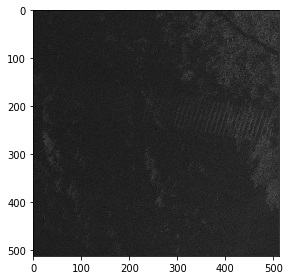

In [46]:
%matplotlib inline
skio.imshow(np.array(img)[:,:,0])
img = np.array(img)

In [47]:
import torch

In [48]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [49]:
def normalize(img):
    img = img/255
    #img.data = (img.data - torch.Tensor(imagenet_stats[0]).reshape(-1,1,1))/torch.Tensor(imagenet_stats[1]).reshape(-1,1,1)
    return img

In [50]:
norm_arr = normalize(torch.Tensor(np.moveaxis(img, 2,0)))

In [51]:
from ceruleanml.inference import logits_to_classes, apply_conf_threshold
import torch

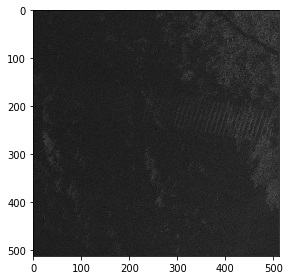

In [52]:
skio.imshow(norm_arr[0,:,:].cpu().detach().numpy())

In [53]:
tracing_model_cpu_pth = "/root/tracing_cpu_224_120__512_36__4_34_0.0003_0.436.pt"

In [54]:
model = torch.jit.load(tracing_model_cpu_pth)

In [55]:
pred_arr = model(norm_arr.unsqueeze(0))

In [56]:
pred_arr.shape

torch.Size([1, 7, 512, 512])

In [57]:
probs,classes = logits_to_classes(pred_arr)

In [58]:
t = apply_conf_threshold(probs, classes, .4)

/root/work/.ice-env/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


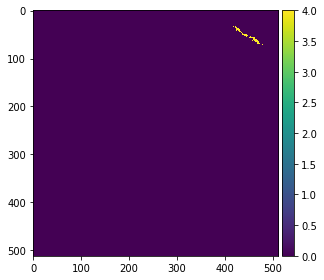

In [59]:
skio.imshow(t.detach().cpu().numpy()[0])

In [60]:
np.unique(t.detach().cpu().numpy())

array([0, 4])